<a href="https://colab.research.google.com/github/kosirobwada/DeepLearningFromZero2/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第3章　word2vec


# カウントベースの手法の問題点

・現実的には、コーパスで扱う語彙数は非常に巨大になる。

・すると、巨大な行列を作らなければならず、SVDを行うのが現実的でない。SVDは、O(N^3)

# 推論ベースの手法

・ニューラルネットワークを用いる場合は、ミニバッチ学習をする。

・ミニバッチ学習をするとは、一度に少量のミニバッチの学習サンプルを見ながら重み更新を繰り返す。

・推論ベースの手法では、学習データの一部を使って逐次的に計算する。

・これにより、計算量が膨大で処理が難しい場合でも、ニューラルネットワークでは処理を小分けにして実行できる。

# one-hot 表現

・one-hot表現とは、ベクトルの要素の中でひとつだけが1で残りが0のベクトル。

In [ ]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.dot(c,W)
print(h)

[[-0.18300872  1.52038272  0.96223897]]


In [ ]:
class MatMul:
  def __init__(self,W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None

  def forward(self, x):
    W, = self.params
    out = np.dot(x, W)
    self.x = x
    return out

  def backward(self, dout):
    W, = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    self.grads[0][...] = dW
    return dx

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.14192312  0.65870819  1.16475768]]


# CBOW(Continuous Bag-Of-Words)

・CBOWモデルは、コンテクストから、ターゲットを推測することを目的としたニューラルネットワークのモデル。

・ターゲットは、中央の単語、その周辺の単語がコンテクスト

・CBOWモデルをできるだけ正確な推測ができるように訓練することで、私たちは単語の分散表現を獲得することができる。

・CBOWモデルへの入力は、単語のリスト。それをone-hot表現に変換することで、CBOWモデルが処理できるように調整する。

・入力層としてN個の単語を扱うのであれば、N個の入力層が存在。

In [ ]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.64544172 -0.08348532  0.16479746 -2.22382516  0.25740015  0.82392375
   0.73392399]]


# CBOWモデルの学習

・これまで見てきたCBOWモデルは、出力層ごとに各単語のスコアを出力してきた。

・このスコアに対して、Softmax関数を適用することで、確率を得ることができる。

・この確率は、コンテクストが与えられたときに、その中央にどの単語が出現するのかを表す。

In [ ]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.',' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])

  return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t==0:
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [ ]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [ ]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)

        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)

contexts = convert_one_hot(contexts, vocab_size)

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # if training data is one-hot-vector
    # then convert to teaching label's index
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None # output of softmax
        self.t = None # teaching data label

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # if teaching data label is one-hot vector
        # then convert to answer data index
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx



In [31]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V ,H = vocab_size, hidden_size

    W_in = 0.01 * np.random.randn(V,H).astype('f')
    W_out = 0.01 * np.random.randn(H,V).astype('f')

    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [],[]
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:,0])
    h1 = self.in_layer1.forward(contexts[:,1])
    h = (h1 + h0) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [ ]:
def forward(self, contexts, target):
  h0 = self.in_layer0.forward(contexts[:,0])
  h1 = self.in_layer1.forward(contexts[:,1])
  h = (h1 + h0) * 0.5
  score = self.out_layer.forward(h)
  loss = self.loss_layer.forward(score, target)
  return loss

In [ ]:
def backward(self, dout=1):
  ds = self.loss_layer.backward(dout)
  da = self.out_layer.backward(ds)
  da *= 0.5
  self.in_layer1.backward(da)
  self.in_layer0.backward(da)
  return None

In [35]:
import numpy
import time
import matplotlib.pyplot as plt
import numpy as np


def clip_grads(grads, max_norm):
    total_norm = 0

    for grad in grads:
        total_norm += np.sum(grad ** 2)

    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)

    if rate < 1:
        for grad in grads:
            grad *= rate


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        """
        train data
        :param x: input data
        :param t: teacher label
        :param max_epoch: times of learning epoch
        :param batch_size: sizes of min batch
        :param max_grad: max norm of grad. if norm of grads is over this value, decline grad
                        (grad clipping: see chapter 05 for more detail)
        :param eval_interval: print results interval
        :return:
        """
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # shuffle
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # calculate grad and update parameters
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)

                if max_grad is not None:
                    clip_grads(grads, max_grad)

                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d | iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        """
        plotting data
        :param ylim: display range of y axis
        :return:
        """
        x = numpy.arange(len(self.loss_list))

        if ylim is not None:
            plt.ylim(*ylim)

        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

def remove_duplicate(params, grads):
    """
    remove duplicate at parameters array
    and adds grad
    :param params:
    :param grads:
    :return:
    """
    params, grads = params[:], grads[:] # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # in case weight sharing
                if params[i] is params[j]:
                    grads[i] += grads[j]
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # in case weight tying
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break
        if not find_flg: break

    return params, grads



In [36]:
class Adam:
    """
    Adam (http://arxiv.org/abs/1412.6980v8)
    """
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []

            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i] ** 2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

| epoch 1 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 | iter 1 / 2 | time 0[s] | loss 1.94
|

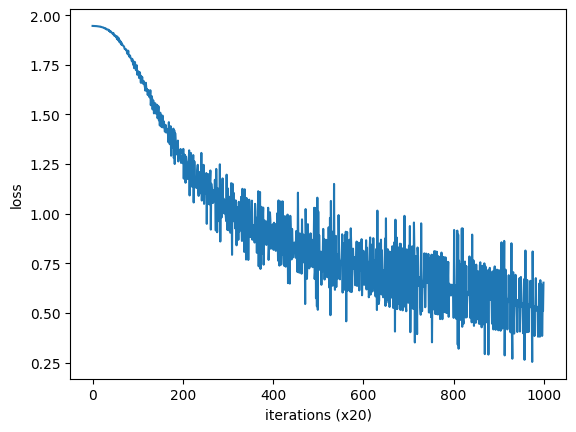

In [37]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [40]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [ 1.0136161 -1.0330466 -1.0292928 -1.6887484  1.0260006]
say [-1.113763   1.0926903  1.1191225  1.3433295 -1.1823403]
goodbye [ 0.9823285  -1.0129724  -0.9750915   0.72044724  0.9741136 ]
and [-1.4334636   1.4866273   1.3812093   0.13747354 -1.1992091 ]
i [ 0.96409297 -0.9952217  -0.9789082   0.710729    0.9682905 ]
hello [ 1.0279342 -1.0312916 -1.0494803 -1.682684   0.9975571]
. [-0.04207537 -0.12029526  0.14242621  1.6027398  -0.7034998 ]


# 3章のまとめ

・推論ベースの手法では、推測することを目標として、その副産物としての単語の分散表現を得る。

・word2vecは推論ベースの手法であり、シンプルな2層のニューラルネットワークで構成されている。

・word2vecには、CBOWモデルとskip-gramモデルがある。

・CBOWモデルは、複数の単語（コンテクスト）から、ひとつの単語（ターゲット）を推測する。

・skip-gramモデルでは、逆に、ひとつの単語（ターゲット）から、複数の単語を予測する。

・word2vecは、重みの再学習ができるため、単語の分散表現の更新や、追加が効率的に行える。